### Libararies

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
sys.path.append('/home/hrai/codes/hpe_library/')
from lib_import import *
from my_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load dataset

In [4]:
h36m_3d_world, h36m_cam_param = load_h36m()

subject = 'S1'
action = 'Walking'
action_list = h36m_3d_world._data[subject].keys()
pose3d_s1_walking = h36m_3d_world._data[subject][action]['positions'] # 3d skeleton sequence wrt world CS
cam_info_s1_walking = h36m_3d_world._data[subject][action]['cameras']
cam_param_s1_walking = get_cam_param(cam_info_s1_walking, subject, h36m_cam_param)

# camera parameters
W, H = cam_param_s1_walking['54138969']['W'], cam_param_s1_walking['54138969']['H']
cam_54138969_ext = cam_param_s1_walking['54138969']['ext']
cam_54138969_int = cam_param_s1_walking['54138969']['int']
cam_54138969_proj = cam_param_s1_walking['54138969']['proj']
cam_54138969_origin = cam_param_s1_walking['54138969']['C']

# 3d trajectory
torso_trajectory = get_part_traj(pose3d_s1_walking, 'torso')
pelvis_trajectory = get_part_traj(pose3d_s1_walking, 'pelvis')
l_hip_trajectory = get_part_traj(pose3d_s1_walking, 'l_hip')
l_shoulder_trajectory = get_part_traj(pose3d_s1_walking, 'l_shoulder')
r_shoulder_trajectory = get_part_traj(pose3d_s1_walking, 'r_shoulder')
r_hip_trajectory = get_part_traj(pose3d_s1_walking, 'r_hip')
lower_line_trajectory = get_part_traj(pose3d_s1_walking, 'lower_line')

# World frame
world_frame = generate_world_frame()

==> Loading 3D data wrt World CS...


### Check (new) DH matrix

In [5]:
import sympy as s
a = s.Matrix([[s.cos('theta1'), -s.sin('theta1'), 0, 0], 
            [s.sin('theta1'), s.cos('theta1'), 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]])
b = s.Matrix([[s.cos('theta2'), 0, -s.sin('theta2'), 0], 
            [0, 1, 0, 0],
            [s.sin('theta2'), 0, s.cos('theta2'), 0],
            [0, 0, 0, 1]])
c = s.Matrix([[1, 0, 0, 'l'],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]])
a*b*c


Matrix([
[cos(theta1)*cos(theta2), -sin(theta1), -sin(theta2)*cos(theta1), l*cos(theta1)*cos(theta2)],
[sin(theta1)*cos(theta2),  cos(theta1), -sin(theta1)*sin(theta2), l*sin(theta1)*cos(theta2)],
[            sin(theta2),            0,              cos(theta2),             l*sin(theta2)],
[                      0,            0,                        0,                         1]])

In [6]:
DH_matrix(radians(45), radians(45), 1)

array([[ 0.5       , -0.70710678, -0.5       ,  0.5       ],
       [ 0.5       ,  0.70710678, -0.5       ,  0.5       ],
       [ 0.70710678,  0.        ,  0.70710678,  0.70710678],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

### Test two link with new DH matrix

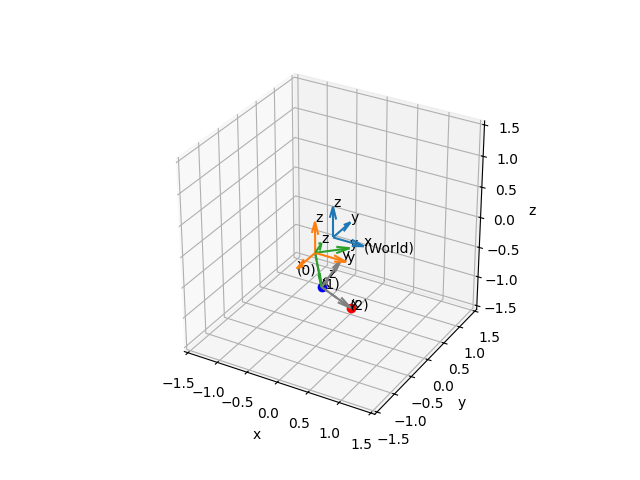

In [7]:
start_point = np.array([0, -0.5, 0])

# initial setting
origin = start_point
Rot_z_minus_90 = Rotation.from_rotvec(-np.pi/2 * np.array([0, 0, 1])).as_matrix()
root_tf = np.eye(4)
root_tf[:3, :3] = Rot_z_minus_90
root_tf[:3, 3] = origin

m01 = DH_matrix(theta=radians(45), alpha=radians(-45), d=0.5)
m12 = DH_matrix(theta=radians(45), alpha=radians(0), d=0.5)
m02 = m01 @ m12
link1_tf = root_tf @ m01
link2_tf = root_tf @ m02
next_point = link1_tf[:3, 3]
final_point = link2_tf[:3, 3]
link1_vec = next_point - start_point
link2_vec = final_point - next_point

root_R = root_tf[:3, :3]
link1_R = link1_tf[:3, :3]
link2_R = link2_tf[:3, :3]
root_frame = generate_dh_frame(origin, root_R.transpose(), '0')
link1_frame1 = generate_dh_frame(start_point, link1_R.transpose(), '1')
link2_frame2 = generate_dh_frame(next_point, link2_R.transpose(), '2')

# -------------------------------------
%matplotlib widget
fig9 = plt.figure(91)
fig9.clear()
ax = fig9.add_subplot(111, projection="3d")
set_xyzlim3d(-1.5, 1.5)
ax.set_aspect('equal', 'box')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

generate_world_frame().draw3d()
ax.plot(next_point[0], next_point[1], next_point[2], 'ob')
ax.plot(final_point[0], final_point[1], final_point[2], 'or')
root_frame.draw3d(color='tab:orange')
link1_frame1.draw3d(color='tab:green')
link2_frame2.draw3d(color='tab:gray')
ax.plot(*np.c_[start_point, next_point], color="tab:gray", ls='--' )
ax.plot(*np.c_[next_point, final_point], color="tab:gray", ls='--' )

plt.show()

### Test two link model with new DH matrix with GUI

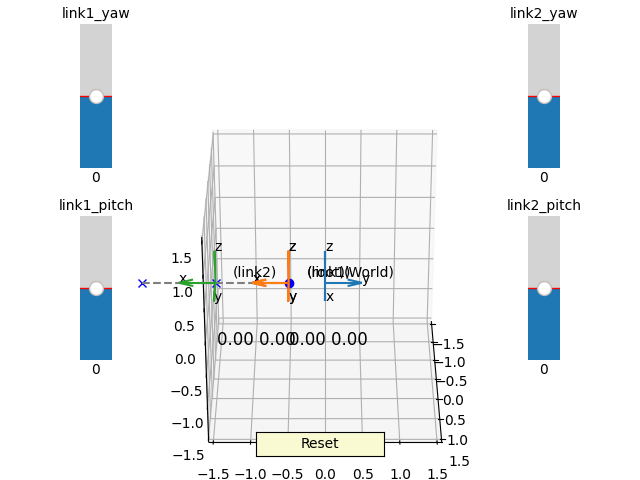

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.widgets import Slider, Button
%matplotlib widget

# plot setting
fig11 = plt.figure(11)
fig11.clear()
ax1 = fig11.add_axes([0, 0, 1, 0.8], projection = '3d')
ax1.view_init(elev=30, azim=0)
ax1.set_aspect('equal', 'box')
world_frame = generate_world_frame()

# GUI setting
ax_link1_yaw = fig11.add_axes([0.1, 0.65, 0.1, 0.3])
ax_link1_pitch = fig11.add_axes([0.1, 0.25, 0.1, 0.3])
ax_link2_yaw = fig11.add_axes([0.8, 0.65, 0.1, 0.3])
ax_link2_pitch = fig11.add_axes([0.8, 0.25, 0.1, 0.3])
ax_reset = fig11.add_axes([0.4, 0.05, 0.2, 0.05])

link1_yaw_init, link1_pitch_init = 0, 0
link2_yaw_init, link2_pitch_init = 0, 0
link1_length, link2_length = 1, 1

s_link1_yaw   = Slider(ax = ax_link1_yaw, label = 'link1_yaw', valmin = -180, valmax = 180, valinit = link1_yaw_init, orientation="vertical")
s_link1_pitch = Slider(ax = ax_link1_pitch, label = 'link1_pitch', valmin = -90, valmax = 90, valinit = link1_pitch_init, orientation="vertical")
s_link2_yaw   = Slider(ax = ax_link2_yaw, label = 'link2_yaw', valmin = -180, valmax = 180, valinit = link2_yaw_init, orientation="vertical")
s_link2_pitch = Slider(ax = ax_link2_pitch, label = 'link2_pitch', valmin = -90, valmax = 90, valinit = link2_pitch_init, orientation="vertical")
button = Button(ax_reset, 'Reset', color='lightgoldenrodyellow', hovercolor='0.975')

start_point = np.array([0, -0.5, 0])

# initial setting
origin = start_point
Rot_z_minus_90 = Rotation.from_rotvec(-np.pi/2 * np.array([0, 0, 1])).as_matrix()
root_tf = np.eye(4)
root_tf[:3, :3] = Rot_z_minus_90
root_tf[:3, 3] = origin
link1_length, link2_length = 1, 1

def update(val):
    # update two link model
    link1_yaw = s_link1_yaw.val
    link1_pitch = s_link1_pitch.val
    link2_yaw = s_link2_yaw.val
    link2_pitch = s_link2_pitch.val
    output = generate_two_link(link1_yaw, link1_pitch, link2_yaw, link2_pitch, l1=link1_length, l2=link2_length, root_tf=root_tf)
    link1_origin, link2_origin, terminal_origin, root_R, link1_R, link2_R, root_frame, link1_frame, link2_frame = output
    
    # link vector
    link1_vec = link2_origin - link1_origin
    link2_vec = terminal_origin - link2_origin
    link1_vec_wrt_root = root_R.T @ link1_vec
    link2_vec_wrt_link1 = link1_R.T @ link2_vec
    
    ik_l1_yaw, ik_l1_pitch = calculate_azimuth_elevation(link1_vec, root_R, degrees=True)
    ik_l2_yaw, ik_l2_pitch = calculate_azimuth_elevation(link2_vec, link1_R, degrees=True)
    
    # plot setting
    azim = ax1.azim
    elev = ax1.elev
    ax1.cla()
    plt.sca(ax1)
    ax1.set_aspect('equal', 'box')
    ax1.set_xlim(-1.5, 1.5)
    ax1.set_ylim(-1.5, 1.5)
    ax1.set_zlim(-1.5, 1.5)
    ax1.view_init(elev, azim)

    # plot
    world_frame.draw3d() # world frame
    
    # draw frame
    root_frame.draw3d(color='tab:red')
    link1_frame.draw3d(color='tab:orange')
    link2_frame.draw3d(color='tab:green')
    
    # draw keypoint
    ax1.plot(link1_origin[0], link1_origin[1], link1_origin[2], 'ob')
    ax1.plot(link2_origin[0], link2_origin[1], link2_origin[2], 'xb')
    ax1.plot(terminal_origin[0], terminal_origin[1], terminal_origin[2], 'xb')
    
    # draw link
    ax1.plot(*np.c_[link1_origin, link2_origin], color="tab:gray", ls='--') 
    ax1.plot(*np.c_[link2_origin, terminal_origin], color="tab:gray", ls='--')

    # print IK results
    ax1.text(link1_origin[0], link1_origin[1], link1_origin[2]-1, '{:.2f} {:.2f}'.format(ik_l1_yaw, ik_l1_pitch), fontsize=12) # link1 ik result
    ax1.text(link2_origin[0], link2_origin[1], link2_origin[2]-1, '{:.2f} {:.2f}'.format(ik_l2_yaw, ik_l2_pitch), fontsize=12) # link2 ik result
    #ax1.text(link2_origin[0], link2_origin[1], link2_origin[2]-2, '{:.2f} {:.2f} {:.2f}'.format(*list(link2_vec_wrt_link1)), fontsize=12) # link2 vec wrt link1 frame
    
        
def reset(event):
    s_link1_yaw.reset()
    s_link1_pitch.reset()
    s_link2_yaw.reset()
    s_link2_pitch.reset()
    
s_link1_yaw.on_changed(update)
s_link1_pitch.on_changed(update)
s_link2_yaw.on_changed(update)
s_link2_pitch.on_changed(update)
 
button.on_clicked(reset)
update(0)

plt.show()

### Batch Appendage Model

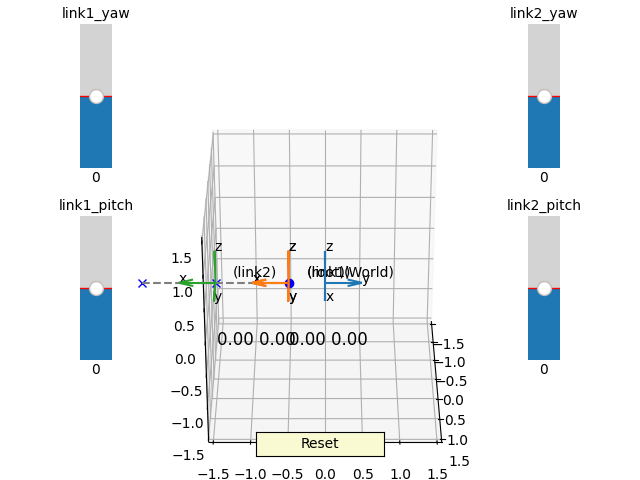

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.widgets import Slider, Button
%matplotlib widget

# plot setting
fig11 = plt.figure(11)
fig11.clear()
ax1 = fig11.add_axes([0, 0, 1, 0.8], projection = '3d')
ax1.view_init(elev=30, azim=0)
ax1.set_aspect('equal', 'box')
world_frame = generate_world_frame()

# GUI setting
ax_link1_yaw = fig11.add_axes([0.1, 0.65, 0.1, 0.3])
ax_link1_pitch = fig11.add_axes([0.1, 0.25, 0.1, 0.3])
ax_link2_yaw = fig11.add_axes([0.8, 0.65, 0.1, 0.3])
ax_link2_pitch = fig11.add_axes([0.8, 0.25, 0.1, 0.3])
ax_reset = fig11.add_axes([0.4, 0.05, 0.2, 0.05])

link1_yaw_init, link1_pitch_init = 0, 0
link2_yaw_init, link2_pitch_init = 0, 0
link1_length, link2_length = 1, 1

s_link1_yaw   = Slider(ax = ax_link1_yaw, label = 'link1_yaw', valmin = -180, valmax = 180, valinit = link1_yaw_init, orientation="vertical")
s_link1_pitch = Slider(ax = ax_link1_pitch, label = 'link1_pitch', valmin = -90, valmax = 90, valinit = link1_pitch_init, orientation="vertical")
s_link2_yaw   = Slider(ax = ax_link2_yaw, label = 'link2_yaw', valmin = -180, valmax = 180, valinit = link2_yaw_init, orientation="vertical")
s_link2_pitch = Slider(ax = ax_link2_pitch, label = 'link2_pitch', valmin = -90, valmax = 90, valinit = link2_pitch_init, orientation="vertical")
button = Button(ax_reset, 'Reset', color='lightgoldenrodyellow', hovercolor='0.975')

start_point = np.array([0, -0.5, 0])

# initial setting
origin = start_point
Rot_z_minus_90 = Rotation.from_rotvec(-np.pi/2 * np.array([0, 0, 1])).as_matrix()
root_tf = np.eye(4)
root_tf[:3, :3] = Rot_z_minus_90
root_tf[:3, 3] = origin

appendage = Appendage(link1_length, link2_length, link1_yaw_init, link1_pitch_init, link2_yaw_init, link2_pitch_init, degree=True, root_tf=root_tf)

def update(val):
    # update two link model
    link1_yaw = s_link1_yaw.val
    link1_pitch = s_link1_pitch.val
    link2_yaw = s_link2_yaw.val
    link2_pitch = s_link2_pitch.val
    appendage.update_link(link1_yaw, link1_pitch, link2_yaw, link2_pitch, degree=True)
    
    ik_l1_yaw, ik_l1_pitch = calculate_azimuth_elevation(appendage.link1_vec, appendage.root_R, degrees=True)
    ik_l2_yaw, ik_l2_pitch = calculate_azimuth_elevation(appendage.link2_vec, appendage.link1_R, degrees=True)
    
    # plot setting
    azim = ax1.azim
    elev = ax1.elev
    ax1.cla()
    plt.sca(ax1)
    ax1.set_aspect('equal', 'box')
    ax1.set_xlim(-1.5, 1.5)
    ax1.set_ylim(-1.5, 1.5)
    ax1.set_zlim(-1.5, 1.5)
    ax1.view_init(elev, azim)

    # plot
    world_frame.draw3d() # world frame
    
    # draw frame
    appendage.root_frame.draw3d(color='tab:red')
    appendage.link1_frame.draw3d(color='tab:orange')
    appendage.link2_frame.draw3d(color='tab:green')
    
    # draw keypoint
    ax1.plot(appendage.link1_origin[0], appendage.link1_origin[1], appendage.link1_origin[2], 'ob')
    ax1.plot(appendage.link2_origin[0], appendage.link2_origin[1], appendage.link2_origin[2], 'xb')
    ax1.plot(appendage.terminal_origin[0], appendage.terminal_origin[1], appendage.terminal_origin[2], 'xb')
    
    # draw link
    ax1.plot(*np.c_[appendage.link1_origin, appendage.link2_origin], color="tab:gray", ls='--') 
    ax1.plot(*np.c_[appendage.link2_origin, appendage.terminal_origin], color="tab:gray", ls='--')

    # print IK results
    ax1.text(appendage.link1_origin[0], appendage.link1_origin[1], appendage.link1_origin[2]-1, '{:.2f} {:.2f}'.format(ik_l1_yaw, ik_l1_pitch), fontsize=12) # link1 ik result
    ax1.text(appendage.link2_origin[0], appendage.link2_origin[1], appendage.link2_origin[2]-1, '{:.2f} {:.2f}'.format(ik_l2_yaw, ik_l2_pitch), fontsize=12) # link2 ik result
    #ax1.text(link2_origin[0], link2_origin[1], link2_origin[2]-2, '{:.2f} {:.2f} {:.2f}'.format(*list(link2_vec_wrt_link1)), fontsize=12) # link2 vec wrt link1 frame
    
        
def reset(event):
    s_link1_yaw.reset()
    s_link1_pitch.reset()
    s_link2_yaw.reset()
    s_link2_pitch.reset()
    
s_link1_yaw.on_changed(update)
s_link1_pitch.on_changed(update)
s_link2_yaw.on_changed(update)
s_link2_pitch.on_changed(update)
 
button.on_clicked(reset)
update(0)

plt.show()

### DH model

In [11]:
%matplotlib widget

    
init_pose_3d = pose3d_s1_walking[0]
dh_model = DHModel(init_pose_3d)
videowriter = imageio.get_writer('/home/hrai/codes/MotionBERT/custom_codes/DHDST/dh_test_h36m_pose_walking.mp4', fps=30)
mpjpe = 0
for frame in tqdm(range(500)): # tqdm(range(len(pose3d_s1_walking))):
    pose_3d = pose3d_s1_walking[frame]
    dh_model.set_dh_model_from_pose(pose_3d)
    mpjpe += dh_model.mpjpe(pose_3d)
    # plot
    fig = plt.figure(17)
    fig.clear()
    ax = axes_3d(fig, rect=[0, 0, 1, 1], xlim=(-2, 2), ylim=(-2, 2), zlim=(0, 2), view=(20, -90))
    dh_model.draw(ax, draw_frame=True, scale=0.1, fontsize=5)
    draw_3d_pose(ax, pose_3d)
    #plt.savefig('/home/hrai/codes/PoseAdaptor/dh_test/dh_test{}.png'.format(frame), dpi=300)
    #plt.show()
    canvas = FigureCanvas(fig)
    canvas.draw()
    image_from_plot = np.array(canvas.renderer._renderer)
    image_from_plot = cv2.cvtColor(image_from_plot, cv2.COLOR_RGB2BGR)           
    videowriter.append_data(image_from_plot)
    #break
    
videowriter.close()
print(mpjpe/len(pose3d_s1_walking))

100%|██████████| 500/500 [00:48<00:00, 10.29it/s]

6.335260808765743e-09


In [12]:
dh_model.get_dh_angles(by_dict=True, degree=True)

{'h_l1_yaw': 39.952247420496086,
 'h_l1_pitch': 44.56255629311203,
 'ra_l1_yaw': 162.02043309557314,
 'ra_l1_pitch': -55.11402363725547,
 'ra_l2_yaw': 22.750456496710505,
 'ra_l2_pitch': -54.557028233234604,
 'la_l1_yaw': -108.52404261969097,
 'la_l1_pitch': -63.30177219319141,
 'la_l2_yaw': -23.624905850562236,
 'la_l2_pitch': -51.76691691699887,
 'rl_l1_yaw': -84.80354092996356,
 'rl_l1_pitch': -76.42052273285388,
 'rl_l2_yaw': -23.577070672687515,
 'rl_l2_pitch': -63.99668688515306,
 'll_l1_yaw': 30.05601170428101,
 'll_l1_pitch': -71.44547467751374,
 'll_l2_yaw': -15.980601680800643,
 'll_l2_pitch': -7.492974371133933}

### Test Batch Appendage model

In [13]:
pose3d_s1_walking[:2].shape

(2, 17, 3)

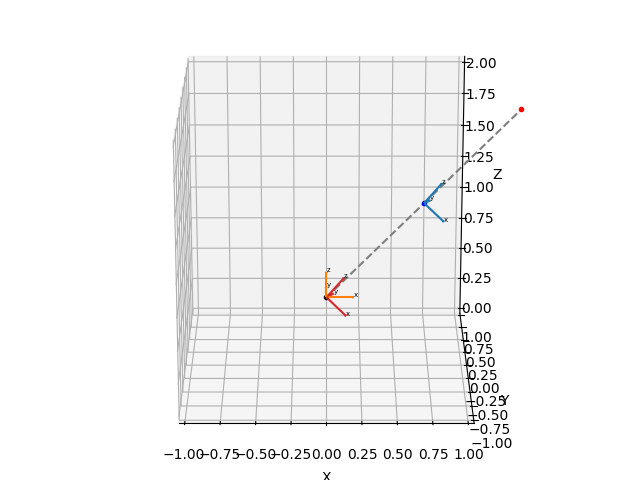

In [14]:
batch_size = 1
num_frames = 243
data_type = torch.float32
device = 'cuda'

batch_link1_length     = torch.ones(batch_size, num_frames)
batch_link2_length     = torch.ones(batch_size, num_frames)
batch_link1_yaw_init   = torch.ones(batch_size, num_frames) * 20
batch_link1_pitch_init = torch.ones(batch_size, num_frames) * 40
batch_link2_yaw_init   = torch.ones(batch_size, num_frames) * 0
batch_link2_pitch_init = torch.ones(batch_size, num_frames) * 0
root_tf = np.eye(4)
root_tf[:3, 3] = np.array([0, 0, 0.5])
batch_root_tf = torch.tensor(root_tf, dtype=torch.float32).unsqueeze(0).unsqueeze(0).repeat(batch_size, num_frames, 1, 1)


batch_appendage = BatchAppendage(batch_link1_length, batch_link2_length, batch_link1_yaw_init, batch_link1_pitch_init, batch_link2_yaw_init, batch_link2_pitch_init, 
                                 degree=True, batch_root_tf=batch_root_tf, device='cuda')

%matplotlib widget
fig = plt.figure(84)
fig.clear()
ax = axes_3d(fig, rect=[0, 0, 1, 1], xlim=(-1, 1), ylim=(-1, 1), zlim=(0, 2), view=(20, -90))
batch_num = 0
frame_num = -1
batch_appendage.draw(ax, batch_num, frame_num, draw_frame=True, scale=0.2, fontsize=5)
plt.show()

### Test Batch DH model

In [9]:
i = 0
num_frames = len(pose3d_s1_walking)
batch_pose_3d = pose3d_s1_walking[num_frames*i:num_frames*(i+1)].reshape(1, num_frames, 17, 3)
batch_dh_model = BatchDHModel(batch_pose_3d, batch_size=1, num_frames=num_frames)
batch_dh_model.batch_mpjpe(batch_pose_3d)

torch.Size([1, 3134, 3, 3]) torch.Size([1, 3134, 3, 1])
torch.Size([1, 3134, 3])
torch.Size([1, 3134, 3, 3]) torch.Size([1, 3134, 3, 1])
torch.Size([1, 3134, 3])
torch.Size([1, 3134, 3, 3]) torch.Size([1, 3134, 3, 1])
torch.Size([1, 3134, 3])
torch.Size([1, 3134, 3, 3]) torch.Size([1, 3134, 3, 1])
torch.Size([1, 3134, 3])
torch.Size([1, 3134, 3, 3]) torch.Size([1, 3134, 3, 1])
torch.Size([1, 3134, 3])
torch.Size([1, 3134, 3, 3]) torch.Size([1, 3134, 3, 1])
torch.Size([1, 3134, 3])
torch.Size([1, 3134, 3, 3]) torch.Size([1, 3134, 3, 1])
torch.Size([1, 3134, 3])
torch.Size([1, 3134, 3, 3]) torch.Size([1, 3134, 3, 1])
torch.Size([1, 3134, 3])


tensor(1.1912e-08, device='cuda:0')

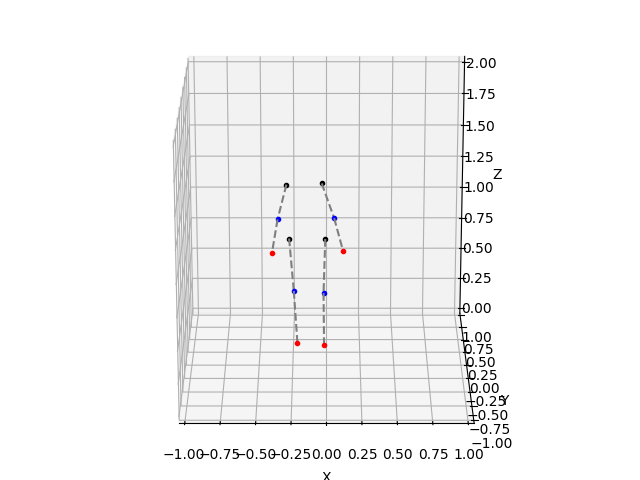

In [31]:
%matplotlib widget
fig = plt.figure(83)
fig.clear()
ax = axes_3d(fig, rect=[0, 0, 1, 1], xlim=(-1, 1), ylim=(-1, 1), zlim=(0, 2), view=(20, -90))
for frame_num in range(0, num_frames, 1):
    batch_dh_model.draw(ax, 0, frame_num, draw_frame=False)
    break
plt.show()

In [21]:
batch_dh_model.get_batch_pose_3d().shape

torch.Size([1, 3134, 17, 3])

In [22]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import imageio

videowriter = imageio.get_writer('/home/hrai/codes/MotionBERT/custom_codes/DHDST/test_batch_dh_model.mp4', fps=30)

stride = 1
fig = plt.figure()
for frame in tqdm(range(0, len(pose3d_s1_walking), stride)):
    fig.clear()
    ax = axes_3d(fig, rect=[0, 0, 1, 1], xlim=(-2, 2), ylim=(-2, 2), zlim=(0, 2), view=(20, -90))
    batch_dh_model.draw(ax, 0, frame, draw_frame=True, draw_gt=True)
    
    canvas = FigureCanvas(fig)
    canvas.draw()
    image_from_plot = np.array(canvas.renderer._renderer)
    image_from_plot = cv2.cvtColor(image_from_plot, cv2.COLOR_RGB2BGR)
    videowriter.append_data(image_from_plot)
videowriter.close()

100%|██████████| 3134/3134 [05:15<00:00,  9.94it/s]


In [54]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# from multiprocessing import Pool

# def generate_plot_image(frame):
#     fig = plt.figure()
#     ax = axes_3d(fig, rect=[0, 0, 1, 1], xlim=(-2, 2), ylim=(-2, 2), zlim=(0, 2), view=(20, -90))
#     batch_dh_model.draw(ax, 0, frame, draw_frame=True, draw_gt=False)
#     canvas = FigureCanvas(fig)
#     canvas.draw()
#     image_from_plot = np.array(canvas.renderer._renderer)
#     image_from_plot = cv2.cvtColor(image_from_plot, cv2.COLOR_RGB2BGR)
#     return image_from_plot

# workers = os.cpu_count()
# if __name__ == '__main__':
#     with Pool(workers) as p:
#         print(p.map(generate_plot_image, [0, 1, 2]))
